# 中介分析

### 黄荣贵（复旦大学社会学系）

## 中介分析基本框架

假定\\(Y\\)是因变量，\\(X\\)是自变量，\\(M\\)是中介变量；其中，\\(X\\)部分（或完全）通过影响\\(M\\)而影响\\(Y\\)。这一关系可以表述为：

$$Y = \alpha_y + \beta_{yx} X + \epsilon_y$$

$$M = \alpha_m + \beta_{mx} X + \epsilon_m$$

$$Y = \alpha + \beta_{m} M + \beta_{x} X + \epsilon$$

如果我们将第二个公式代入到第三个公式，然后与第一个公式进行比较可以发现：

$$ \beta_{mx}\beta_m = \beta_{yx} - \beta_x$$

因此，只要我们估计第一个和第三个模型就可以得到中介效应 $\beta_{mx}\beta_m$。然而，为了估计中介效应是否显著，我们还需要估计相应的标准误$\widehat{\sigma_{\beta_{mx}\beta_m}}$。其中一种估计方法（Sobel，1982）如下：

$$\widehat{\sigma_{\beta_{mx}\beta_m}} = \sqrt{\widehat{\beta_{mx}^2} \widehat{\sigma^2_{\beta_{m}}}+\widehat{\beta_{m}^2} \widehat{\sigma^2_{\beta_{mx}}} }$$

可见，为了估计中介效应的标准误，需要同时估计第二和第三个模型。

得到标准误后，可以使用正态分布来估计其置信区间。然而，值得注意的是，由于中介效应呈偏态分布，根据上述标准误计算的置信区间无法很好反映真实的区间。

In [1]:
data(Prestige, package="carData")

names(Prestige)

[1] "education" "income"    "women"     "prestige"  "census"    "type"

### 例子:教育程度在多大程度上通过收入而影响职业声望？

#### 手工计算中介效应

通过拟合三个模型，我们可以通过两种不同的方法计算中介效应。

In [2]:
mod_y <- lm(prestige ~ education, data = Prestige)
mod_m <- lm(income ~ education, data = Prestige)
mod_full <- lm(prestige ~ income + education, data = Prestige)
coef(mod_m)['education'] * coef(mod_full)['income']  # mediation effect by multiplication

education 
 1.223433

In [3]:
med_eff <- coef(mod_y)['education'] - coef(mod_full)['education']  # mediation effect by subtraction
med_eff  # save for futher use

education 
 1.223433

下面我们直接计算中介效应的标准误，以及对95%置信的估计。

In [4]:
sd_eff_sq <- coef(mod_m)['education']^2 * vcov(mod_full)['income', 'income'] + 
             coef(mod_full)['income']^2 * vcov(mod_m)['education', 'education']
sd_eff <- sqrt(sd_eff_sq)  # SE of mediation effect
sd_eff

education 
0.2655414

In [5]:
med_eff / sd_eff # Z value

education 
 4.607317

In [6]:
c(med_eff - 1.96*sd_eff, med_eff + 1.96*sd_eff)  # 95% CI

education education 
0.7029722 1.7438945

我们可以把上面的计算过程封装起来，从而得到计算中介效应及其区间的函数。

#### 使用sobel函数进行中介分析

In [7]:
library(multilevel)

Loading required package: nlme
Loading required package: MASS


In [8]:
with(Prestige, sobel(education, income, prestige))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-10.731982,3.6770883,-2.918609,4.343443e-03
pred,5.360878,0.3319882,16.147796,1.286264e-29
,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-6.847778720,3.2189770963,-2.127315,3.587840e-02
pred,4.137444384,0.3489120233,11.858131,1.032202e-20
med,0.001361166,0.0002242121,6.070886,2.355196e-08
,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-2853.5856,1407.0392,-2.028078,4.521163e-02
pred,898.8128,127.0354,7.075294,2.079192e-10


### 通过bootstrap法计算中介效应及其置信区间


Bollen和Stine是这个方法的倡导者。相关讨论详见：Bollen, K. A. & Stine, R. 1990. Direct and indirect effects: classical and bootstrap estimates of variability Sociological Methodology, 20, 115–140.

首先，定义一个函数计算中介效应。该函数具有两个参数，第一个参数是数据框，第二个参数是bootstrap法随机抽取的案例的标识（行数）。

In [9]:
coef_diff <- function(d, i){
    dat <- d[i, ]
    mod_y <- lm(prestige ~ education, data = dat)
    mod_full <- lm(prestige ~ income + education, data = dat)
    med_eff <- coef(mod_y)['education'] - coef(mod_full)['education'] ## mediation effect by subtraction
    med_eff
}

接下来，加载boot程序包，并调用同名函数进行bootstrap计算。其中，我们将抽样次数R设置为1000，stype参数设置为i。

In [10]:
library(boot)

(med.boot <- boot(Prestige, coef_diff, R = 1000, stype="i"))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Prestige, statistic = coef_diff, R = 1000, stype = "i")


Bootstrap Statistics :
    original     bias    std. error
t1* 1.223433 0.03453595   0.2623403

original: 原始样本计算得到的统计量

bias: R次bootstrap得到样本量的均值 - original

std.error: R次bootstrap样本统计量的标准差

第三，调用boot.ci函数计算置信区间。与Bollen and Stine（1990）相一致，我们计算的是percentile置信区间（type = "perc"）。

In [11]:
boot.ci(med.boot, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.782,  1.816 )  
Calculations and Intervals on Original Scale

通过密度图来检查bootstrap结果的分布。同时，通过curve函数增加一个正态分布曲线来做参考。结果显示，bootstrap结果略显偏态分布。

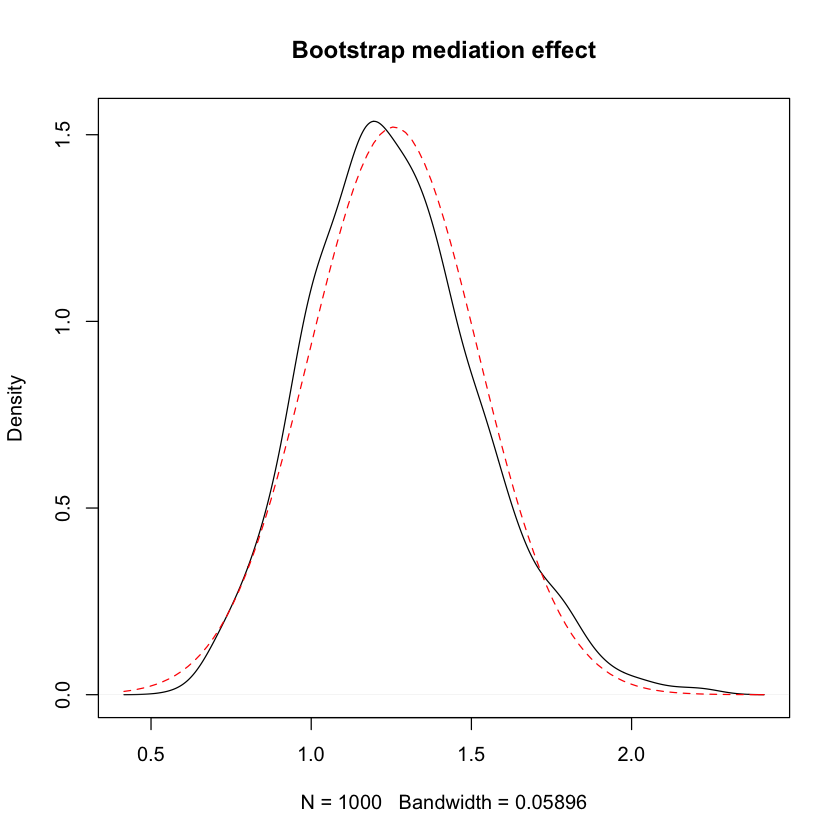

In [12]:
plot(density(med.boot$t), main = "Bootstrap mediation effect")
curve(dnorm(x, mean=mean(med.boot$t), sd=sd(med.boot$t)), add = TRUE, col='red', lty=2)

In [13]:
coef_diff2 <- function(d, i){
    dat <- d[i, ]
    mod_y <- lm(prestige ~ education, data = dat)
    mod_full <- lm(prestige ~ income + education, data = dat)
    med_eff <- coef(mod_y)['education'] - coef(mod_full)['education']  # mediation effect by subtraction
    pct <- med_eff / coef(mod_y)['education']
    c(med_eff, pct)
}

(med.boot2 <- boot(Prestige, coef_diff2, R = 1000, stype="i"))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Prestige, statistic = coef_diff2, R = 1000, stype = "i")


Bootstrap Statistics :
     original      bias    std. error
t1* 1.2234333 0.031194852  0.26331394
t2* 0.2282151 0.006575025  0.05062691

In [14]:
boot.ci(med.boot2, conf=0.95, type="perc", index=1)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot2, conf = 0.95, type = "perc", index = 1)

Intervals : 
Level     Percentile     
95%   ( 0.792,  1.836 )  
Calculations and Intervals on Original Scale

In [15]:
boot.ci(med.boot2, conf=0.95, type="perc", index=2)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot2, conf = 0.95, type = "perc", index = 2)

Intervals : 
Level     Percentile     
95%   ( 0.1457,  0.3453 )  
Calculations and Intervals on Original Scale

### 使用medmod模块计算简单中介效应及其置信区间


In [16]:
library(medmod)

set.seed(1234)
X <- rnorm(10)
M <- 0.5*X + rnorm(10)
Y <- 0.7*M + rnorm(10)
dat <- data.frame(X=X, M=M, Y=Y)

dat

X,M,Y
-1.2070657,-1.0807256,-0.62241968
0.2774292,-0.8596718,-1.09245617
1.0844412,-0.2340333,-0.60437119
-2.3456977,-1.1083900,-0.31628358
0.4291247,1.1740564,0.12811924
0.5060559,0.1427425,-1.34828519
-0.5747400,-0.7983795,0.01589008
-0.5466319,-1.1845113,-1.85281366
-0.5644520,-1.1193977,-0.79871668
-0.8900378,1.9708163,0.44362278


标准的中介分析

In [17]:
med(dat, dep = "Y", pred = "X", med = "M")  # standard method


 MEDIATION

 Mediation Estimates                                  
 ──────────────────────────────────────────────────── 
   Effect      Estimate    SE       Z         p       
 ──────────────────────────────────────────────────── 
   Indirect       0.143    0.160     0.895    0.371   
   Direct        -0.295    0.164    -1.801    0.072   
   Total         -0.151    0.219    -0.690    0.490   
 ──────────────────────────────────────────────────── 

[1] FALSE

In [18]:
med(dat, dep = "Y", pred = "X", med = "M", paths=TRUE)  # show path estimates


 MEDIATION

 Mediation Estimates                                  
 ──────────────────────────────────────────────────── 
   Effect      Estimate    SE       Z         p       
 ──────────────────────────────────────────────────── 
   Indirect       0.143    0.160     0.895    0.371   
   Direct        -0.295    0.164    -1.801    0.072   
   Total         -0.151    0.219    -0.690    0.490   
 ──────────────────────────────────────────────────── 


 Path Estimates                                          
 ─────────────────────────────────────────────────────── 
                  Estimate    SE       Z         p       
 ─────────────────────────────────────────────────────── 
   X    →    M       0.312    0.334     0.935    0.350   
   M    →    Y       0.459    0.149     3.088    0.002   
   X    →    Y      -0.295    0.164    -1.801    0.072   
 ─────────────────────────────────────────────────────── 

[1] FALSE

Loading required namespace: ggplot2
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



 MEDIATION

 Mediation Estimates                                  
 ──────────────────────────────────────────────────── 
   Effect      Estimate    SE       Z         p       
 ──────────────────────────────────────────────────── 
   Indirect       0.143    0.160     0.895    0.371   
   Direct        -0.295    0.164    -1.801    0.072   
   Total         -0.151    0.219    -0.690    0.490   
 ──────────────────────────────────────────────────── 

[1] TRUE

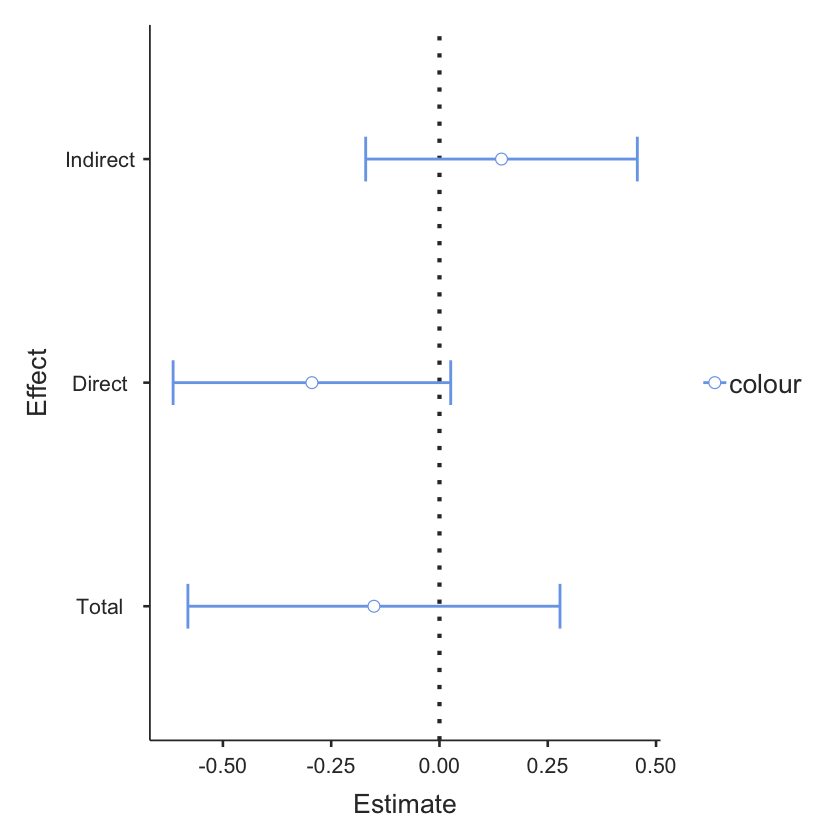

In [19]:
med(dat, dep = "Y", pred = "X", med = "M", estPlot=TRUE)  # plot effects

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



 MEDIATION

 Mediation Estimates                                  
 ──────────────────────────────────────────────────── 
   Effect      Estimate    SE       Z         p       
 ──────────────────────────────────────────────────── 
   Indirect       0.143    0.160     0.895    0.371   
   Direct        -0.295    0.164    -1.801    0.072   
   Total         -0.151    0.219    -0.690    0.490   
 ──────────────────────────────────────────────────── 


 Path Estimates                                          
 ─────────────────────────────────────────────────────── 
                  Estimate    SE       Z         p       
 ─────────────────────────────────────────────────────── 
   X    →    M       0.312    0.334     0.935    0.350   
   M    →    Y       0.459    0.149     3.088    0.002   
   X    →    Y      -0.295    0.164    -1.801    0.072   
 ─────────────────────────────────────────────────────── 

[1] TRUE

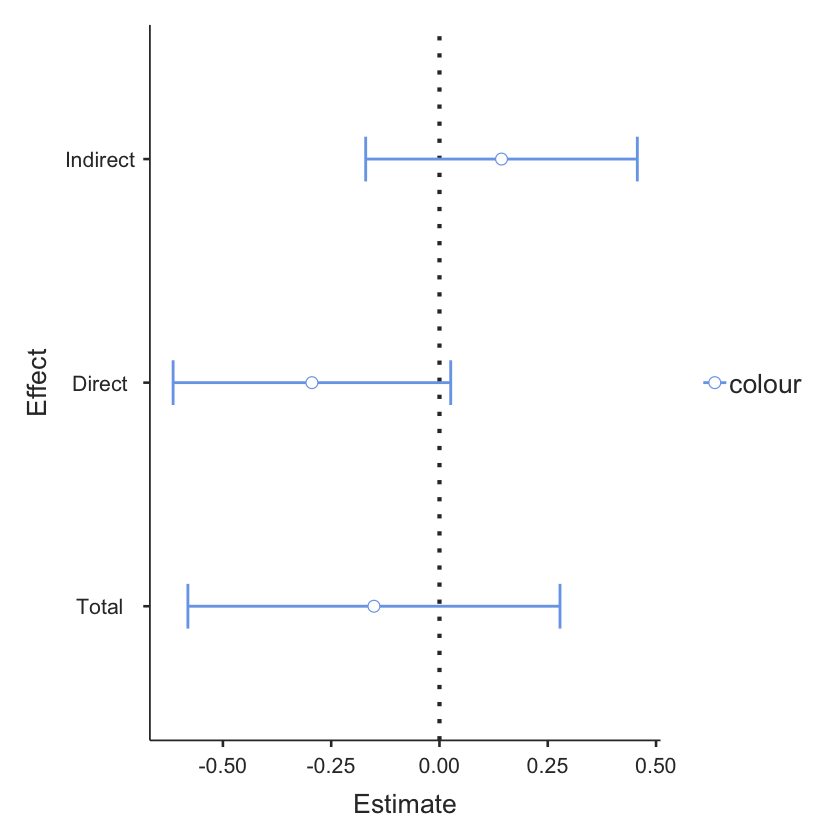

In [20]:
med(dat, dep = "Y", pred = "X", med = "M", paths=TRUE, estPlot=TRUE)  # show paths and plot effects

使用自助法(bootstrap)计算

In [21]:
med(dat, dep = "Y", pred = "X", med = "M", estMethod = "bootstrap")  # use bootstrap method


 MEDIATION

 Mediation Estimates                                  
 ──────────────────────────────────────────────────── 
   Effect      Estimate    SE       Z         p       
 ──────────────────────────────────────────────────── 
   Indirect       0.143    0.237     0.604    0.546   
   Direct        -0.295    0.209    -1.411    0.158   
   Total         -0.151    0.205    -0.737    0.461   
 ──────────────────────────────────────────────────── 

[1] FALSE

In [22]:
med(dat, dep = "Y", pred = "X", med = "M", estMethod = "bootstrap", bootstrap = 500)  
# number of bootstrap, large number is preferred


 MEDIATION

 Mediation Estimates                                  
 ──────────────────────────────────────────────────── 
   Effect      Estimate    SE       Z         p       
 ──────────────────────────────────────────────────── 
   Indirect       0.143    0.237     0.604    0.546   
   Direct        -0.295    0.204    -1.442    0.149   
   Total         -0.151    0.207    -0.732    0.464   
 ──────────────────────────────────────────────────── 

[1] FALSE

In [23]:
med(dat, dep = "Y", pred = "X", med = "M", estMethod = "bootstrap", bootstrap = 500, ci = TRUE) 
# show confidence interval


 MEDIATION

 Mediation Estimates                                                       
 ───────────────────────────────────────────────────────────────────────── 
   Effect      Estimate    SE       Lower     Upper      Z         p       
 ───────────────────────────────────────────────────────────────────────── 
   Indirect       0.143    0.268    -0.208     0.9365     0.535    0.593   
   Direct        -0.295    0.206    -0.882    -0.0280    -1.432    0.152   
   Total         -0.151    0.208    -0.578     0.3086    -0.727    0.467   
 ───────────────────────────────────────────────────────────────────────── 

[1] FALSE